In [1]:
# Install TensorFlow (if necessary) - Colab usually has it pre-installed
!pip install tensorflow

# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

print("Libraries imported successfully.")


Libraries imported successfully.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543839 entries, 0 to 543838
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Station      543839 non-null  object 
 1   Year         543839 non-null  int64  
 2   Month        543839 non-null  int64  
 3   Day          543839 non-null  int64  
 4   Rainfall     543839 non-null  float64
 5   Sunshine     543839 non-null  float64
 6   Humidity     543839 non-null  float64
 7   Temperature  543839 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 33.2+ MB
None
      Station  Year  Month  Day  Rainfall  Sunshine  Humidity  Temperature
0  Ambaganctg  2008      1    1       0.0       9.1      78.0         20.1
1  Ambaganctg  2008      1    2       0.0       5.6      79.0         21.0
2  Ambaganctg  2008      1    3       0.0       8.6      82.0         20.1
3  Ambaganctg  2008      1    4       0.0       9.1      73.0         21.0
4  Ambaganctg  20

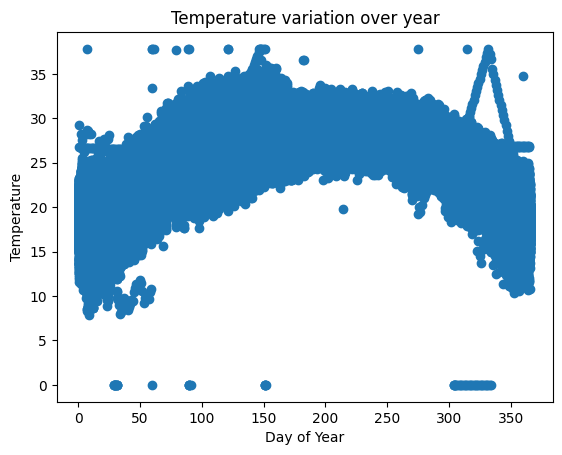

In [39]:
# Load your dataset
df = pd.read_csv('/content/BD_weather.csv')  # Path if uploaded directly to Colab

# Display basic info
print(df.info())
print(df.head())

# Extract relevant features: date, temperature, humidity, rainfall, sunshine
# Adjust column names based on your CSV structure
columns_needed = ['Year', 'Month', 'Day', 'Temperature', 'Humidity', 'Rainfall', 'Sunshine']
df = df[columns_needed].copy() # Use .copy() to avoid SettingWithCopyWarning

# Create a datetime column from 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Convert Date to ordinal or cyclical features
df['DayOfYear'] = df['Date'].dt.dayofyear
X = df[['DayOfYear', 'Humidity', 'Rainfall', 'Sunshine']].values
y = df['Temperature'].values

# Plot to visualize
plt.scatter(df['DayOfYear'], y)
plt.xlabel('Day of Year')
plt.ylabel('Temperature')
plt.title('Temperature variation over year')
plt.show()

In [3]:
# Normalize inputs for better training stability
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

# Convert to tensors
X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y_scaled, dtype=tf.float32)


In [4]:
from tensorflow.keras import layers, models

def build_pinn_model():
    model = models.Sequential([
        layers.Dense(64, activation='tanh', input_shape=(X_tensor.shape[1],)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)  # Output temperature prediction
    ])
    return model

model = build_pinn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def physics_loss(x, prediction):
    # Example: enforce seasonal sinusoidal variation
    # Extract day of year from input features (assuming standardized, recover original)
    day_of_year = x[:,0]
    # For simplicity, include a sinusoidal physics constraint on temperature
    seasonal_component = tf.sin(day_of_year * 2 * np.pi)

    # Physics-based residual: (predicted temperature) - (seasonal expected temp)
    physics_residual = prediction - seasonal_component
    physics_loss_value = tf.reduce_mean(tf.square(physics_residual))
    return physics_residual, physics_loss_value


In [6]:
def total_loss(y_true, y_pred, x):
    # Data MSE Loss
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    # Physics Loss
    _, phys_loss = physics_loss(x, y_pred)
    # Combine with weighting factor
    total = data_loss + 0.1 * phys_loss
    return total


In [7]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: total_loss(y_true, y_pred, X_tensor))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [9]:
history = model.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_test_tensor, y_test_tensor),
    epochs=100,
    batch_size=256
)


Epoch 1/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.5016 - val_loss: 0.2731
Epoch 2/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.2653 - val_loss: 0.2645
Epoch 3/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.2618 - val_loss: 0.2624
Epoch 4/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2614 - val_loss: 0.2608
Epoch 5/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2592 - val_loss: 0.2634
Epoch 6/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2598 - val_loss: 0.2631
Epoch 7/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2585 - val_loss: 0.2596
Epoch 8/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2587 - val_loss: 0.2627
Epoch 9/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2584 - val_loss: 0.2599
Epoch 10/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2585 - val_loss: 0.2613
Epoch 11/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2593 - val_loss: 0.2599
Epoch 12/100


In [22]:
# Evaluate
test_loss = model.evaluate(X_test_tensor, y_test_tensor)
print("Test Loss:", test_loss)

# Predict and invert scaling
y_pred_scaled = model.predict(X_test_tensor)
print(f"Shape of y_pred_scaled: {y_pred_scaled.shape}") # Add this line
y_pred = scaler_y.inverse_transform(y_pred_scaled)
print(f"Shape of y_pred after inverse_transform: {y_pred.shape}") # Add this line

# Save to CSV
import pandas as pd
results = pd.DataFrame({
    'y_true': y_true.flatten(),
    'y_pred': y_pred.flatten()
})
results.to_csv('pinn_predictions.csv', index=False)

3399/3399 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2567
Test Loss: 0.25793150067329407
3399/3399 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Shape of y_pred_scaled: (108768, 1)
Shape of y_pred after inverse_transform: (108768, 1)


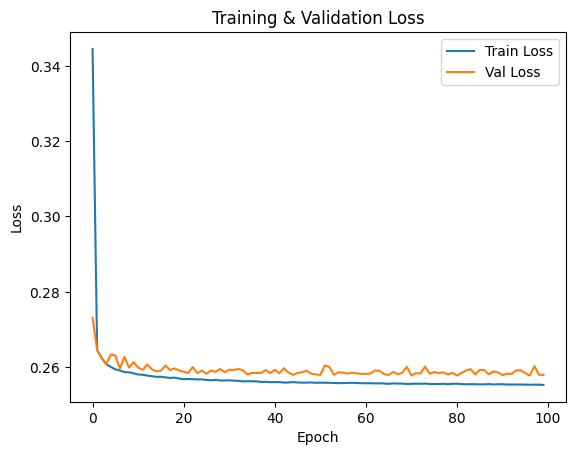

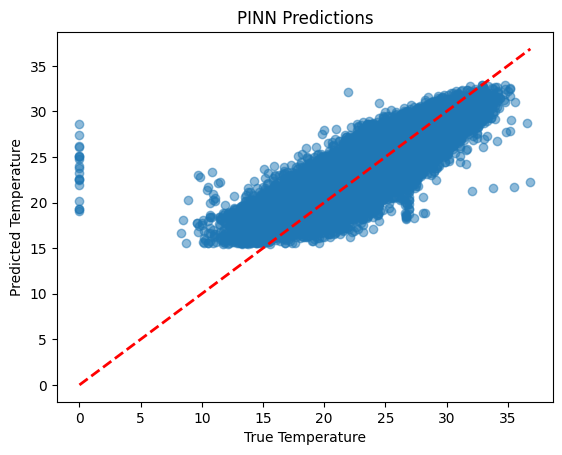

In [11]:
import matplotlib.pyplot as plt

# Loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# True vs Predicted
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.title('PINN Predictions')
plt.show()


In [12]:
model.save('pinn_temperature_model.h5')


Shape of y_true_np: (108768, 1), dtype: float64
Shape of y_pred_np: (108768, 1), dtype: float32
R-squared: 0.8659
Mean Squared Error (MSE): 2.3333
Mean Absolute Error (MAE): 1.1270
Root Mean Squared Error (RMSE): 1.5275


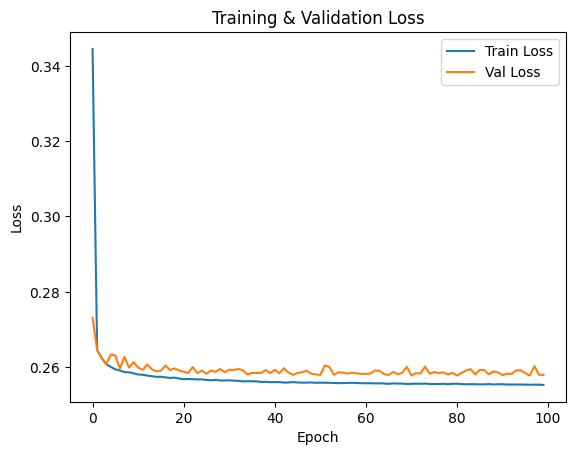

In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Ensure y_true and y_pred are numpy arrays and are 2D arrays with a single column
# Access y_true and y_pred from the results DataFrame to avoid modification issues
y_true_np = results['y_true'].values.reshape(-1, 1)
y_pred_np = results['y_pred'].values.reshape(-1, 1)

# Debugging: Print shapes and types
print(f"Shape of y_true_np: {y_true_np.shape}, dtype: {y_true_np.dtype}")
print(f"Shape of y_pred_np: {y_pred_np.shape}, dtype: {y_pred_np.dtype}")

# Calculate regression metrics
r2 = r2_score(y_true_np, y_pred_np)
mse = mean_squared_error(y_true_np, y_pred_np)
mae = mean_absolute_error(y_true_np, y_pred_np)
rmse = np.sqrt(mse)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot loss curves (already done in the previous cell, but good to keep here for completeness)
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [1]:
import matplotlib.pyplot as plt

# Loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Save the loss curve plot as a PDF file
plt.savefig('loss_curve.pdf', bbox_inches='tight')

plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

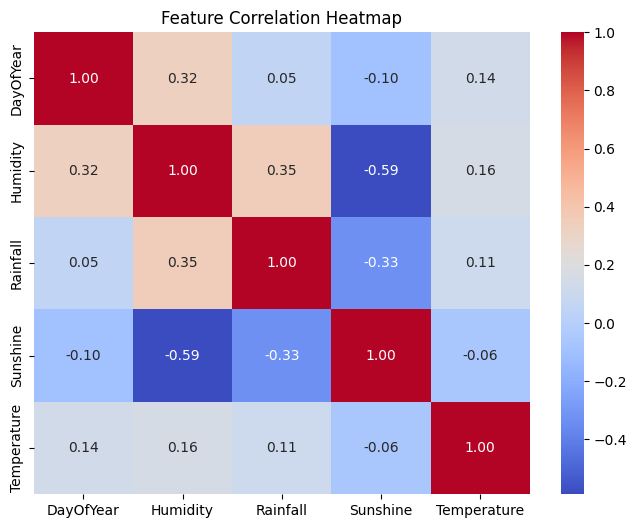

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for correlation analysis
correlation_data = df[['DayOfYear', 'Humidity', 'Rainfall', 'Sunshine', 'Temperature']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')

# Save the heatmap as a PDF file
plt.savefig('feature_correlation_heatmap.pdf', bbox_inches='tight')

plt.show()

# Task
Train a baseline neural network model, generate predictions, and then create four plots to compare the performance of the PINN model against the baseline model: a time series comparison plot, residual plots, a seasonal trend comparison plot, and an enhanced scatter plot. Finally, suggest the two best plots for distinguishing the models.

## Train a baseline model

### Subtask:
Train a standard neural network model (without physics constraints) on the same training data.


**Reasoning**:
Define and compile a standard neural network model for the baseline comparison.



In [26]:
from tensorflow.keras import layers, models

# 1. Define a sequential Keras model named baseline_model
baseline_model = models.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(X_train_tensor.shape[1],)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1)  # Output temperature prediction
])

# 2. Compile the baseline_model using the Adam optimizer and the mean squared error ('mse') loss function.
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Train the baseline model using the prepared training data and store the training history.



In [27]:
# 3. Train the baseline_model
baseline_history = baseline_model.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_test_tensor, y_test_tensor),
    epochs=100,
    batch_size=256
)

Epoch 1/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3963 - val_loss: 0.1383
Epoch 2/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1367 - val_loss: 0.1354
Epoch 3/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1340 - val_loss: 0.1347
Epoch 4/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1333 - val_loss: 0.1332
Epoch 5/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1311 - val_loss: 0.1333
Epoch 6/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1304 - val_loss: 0.1342
Epoch 7/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1305 - val_loss: 0.1311
Epoch 8/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1296 - val_loss: 0.1333
Epoch 9/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1302 - val_loss: 0.1337
Epoch 10/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1309 - val_loss: 0.1328
Epoch 11/100
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1295 - val_loss: 0.1308
Epoch 12/100
1700/1

**Reasoning**:
The first step is to load the data from the CSV file into a pandas DataFrame and display the first few rows to understand its structure.



### Subtask:
Generate predictions using the trained baseline model on the test data.

In [37]:
# Generate predictions with the baseline model
baseline_y_pred_scaled = baseline_model.predict(X_test_tensor)
baseline_y_pred = scaler_y.inverse_transform(baseline_y_pred_scaled)

print(f"Shape of baseline_y_pred: {baseline_y_pred.shape}")

3399/3399 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Shape of baseline_y_pred: (108768, 1)


### Subtask:
Prepare data for plotting by aligning true values, PINN predictions, and baseline predictions.

In [40]:
# Ensure all arrays are in the correct shape (flatten if necessary and reshape to 2D)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
baseline_y_pred_flat = baseline_y_pred.flatten()

# Create a DataFrame for easier handling and plotting
# We need to make sure the indices of y_test correspond to the correct entries in the original df
# Let's use the indices from the train_test_split on the original dataframe

# Re-do the split but keep track of indices
from sklearn.model_selection import train_test_split

# Assuming X_scaled and y_scaled were created from df after adding 'Date' and 'DayOfYear'
# We need to split the original dataframe's index to get the corresponding dates for the test set.
indices = df.index.values
X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(indices, indices, test_size=0.2, random_state=42)

# Now use these indices to get the corresponding dates from the original dataframe
test_dates = df.loc[X_test_idx, 'Date'].reset_index(drop=True)

# Add the dates and DayOfYear to the plot_data DataFrame, ensuring alignment
# We need to align y_test_flat, y_pred_flat, baseline_y_pred_flat with test_dates and test_dayofyear
# The split was done on X_scaled and y_scaled, which are already aligned.
# The indices X_test_idx correspond to the original df, which is now aligned with X_scaled and y_scaled

# Create plot_data using the test set indices to get the corresponding original values
plot_data = df.loc[X_test_idx].copy()
plot_data = plot_data[['Date', 'DayOfYear', 'Temperature']].reset_index(drop=True)
plot_data = plot_data.rename(columns={'Temperature': 'True_Temperature'})

# Add the predictions, ensuring they are aligned with the test set indices
# y_pred and baseline_y_pred are already aligned with X_test_tensor and y_test_tensor
# which in turn are aligned with the order of elements in X_test_idx after the split.
# So, we can directly add the flattened predictions.

plot_data['PINN_Prediction'] = y_pred.flatten()
plot_data['Baseline_Prediction'] = baseline_y_pred.flatten()


# Sort by date for time series plotting
plot_data = plot_data.sort_values(by='Date').reset_index(drop=True)

display(plot_data.head())

,Date,DayOfYear,True_Temperature,PINN_Prediction,Baseline_Prediction
0,1961-01-01,1,22.61,20.506704,20.016577
1,1961-01-01,1,22.20,19.596079,19.090139
2,1961-01-04,4,23.10,18.611677,17.970451
3,1961-01-05,5,16.60,19.492826,18.716465
4,1961-01-05,5,20.90,21.038572,20.152124


### Subtask:
Generate Time Series Comparison Plot

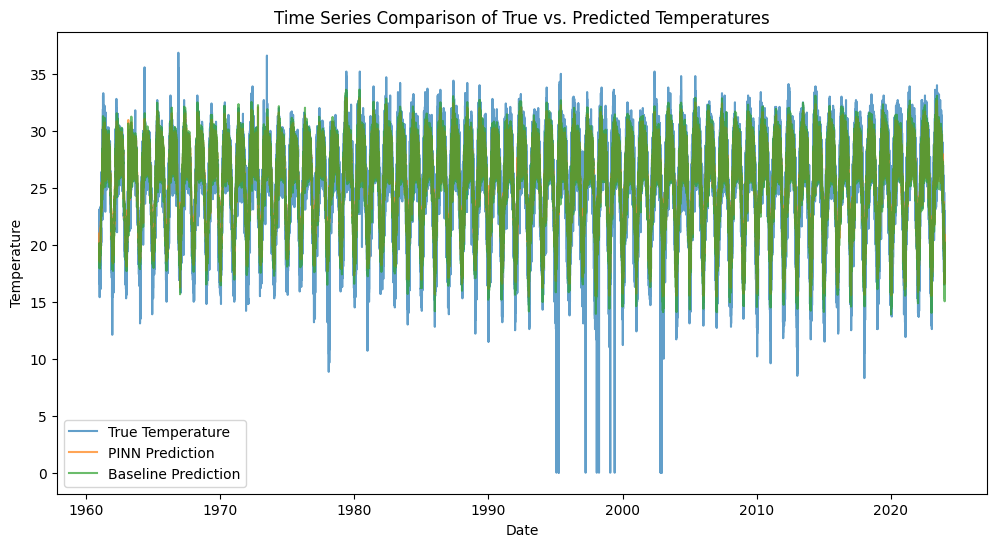

In [41]:
# Time Series Comparison Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_data['Date'], plot_data['True_Temperature'], label='True Temperature', alpha=0.7)
plt.plot(plot_data['Date'], plot_data['PINN_Prediction'], label='PINN Prediction', alpha=0.7)
plt.plot(plot_data['Date'], plot_data['Baseline_Prediction'], label='Baseline Prediction', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Time Series Comparison of True vs. Predicted Temperatures')
plt.legend()
plt.show()

### Subtask:
Generate Residual Plots

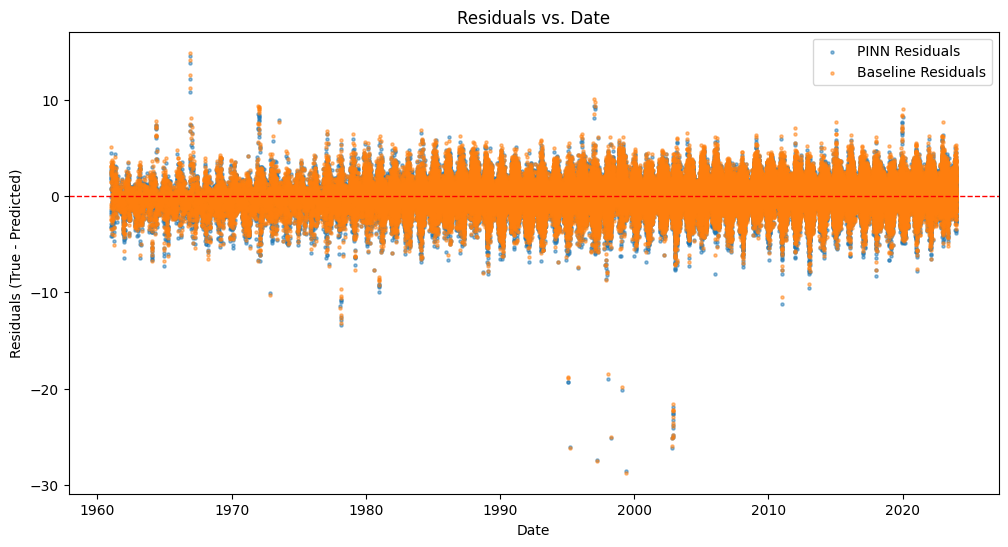

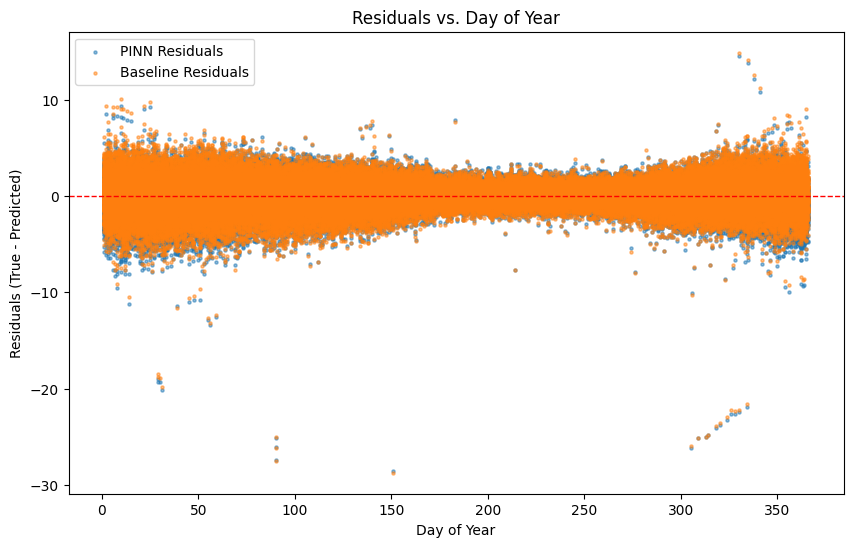

In [46]:
# Calculate Residuals
plot_data['PINN_Residuals'] = plot_data['True_Temperature'] - plot_data['PINN_Prediction']
plot_data['Baseline_Residuals'] = plot_data['True_Temperature'] - plot_data['Baseline_Prediction']

# Residual Plot vs. Date
plt.figure(figsize=(12, 6))
plt.scatter(plot_data['Date'], plot_data['PINN_Residuals'], label='PINN Residuals', alpha=0.5, s=5)
plt.scatter(plot_data['Date'], plot_data['Baseline_Residuals'], label='Baseline Residuals', alpha=0.5, s=5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Date')
plt.legend()
plt.savefig('residuals_vs_date.pdf', bbox_inches='tight') # Save as PDF
plt.show()

# Residual Plot vs. Day of Year
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['DayOfYear'], plot_data['PINN_Residuals'], label='PINN Residuals', alpha=0.5, s=5)
plt.scatter(plot_data['DayOfYear'], plot_data['Baseline_Residuals'], label='Baseline Residuals', alpha=0.5, s=5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Day of Year')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Day of Year')
plt.legend()
plt.savefig('residuals_vs_dayofyear.pdf', bbox_inches='tight') # Save as PDF
plt.show()

### Subtask:
Generate Seasonal Trend Comparison Plot

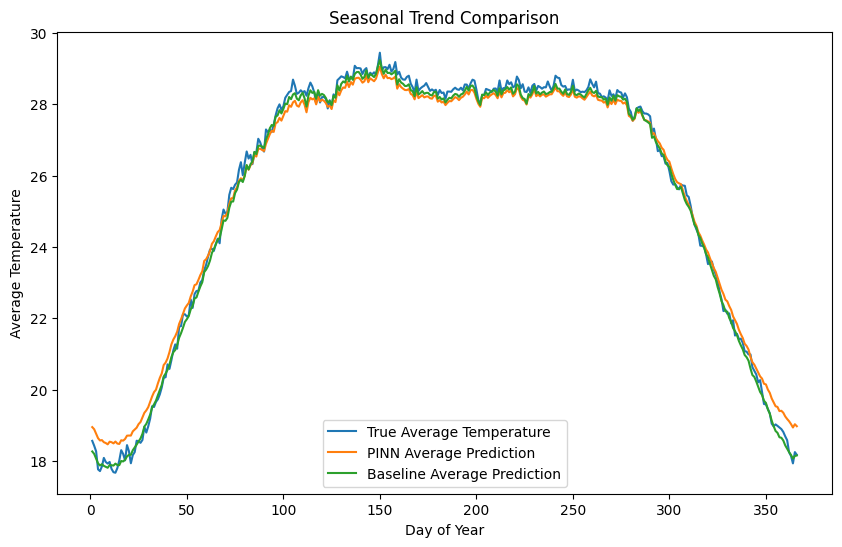

In [45]:
# Calculate average temperature and predictions for each day of the year
seasonal_avg = plot_data.groupby('DayOfYear')[['True_Temperature', 'PINN_Prediction', 'Baseline_Prediction']].mean().reset_index()

# Seasonal Trend Comparison Plot
plt.figure(figsize=(10, 6))
plt.plot(seasonal_avg['DayOfYear'], seasonal_avg['True_Temperature'], label='True Average Temperature')
plt.plot(seasonal_avg['DayOfYear'], seasonal_avg['PINN_Prediction'], label='PINN Average Prediction')
plt.plot(seasonal_avg['DayOfYear'], seasonal_avg['Baseline_Prediction'], label='Baseline Average Prediction')
plt.xlabel('Day of Year')
plt.ylabel('Average Temperature')
plt.title('Seasonal Trend Comparison')
plt.legend()
plt.savefig('seasonal_trend_comparison.pdf', bbox_inches='tight') # Save as PDF
plt.show()

### Subtask:
Generate Enhanced Scatter Plot

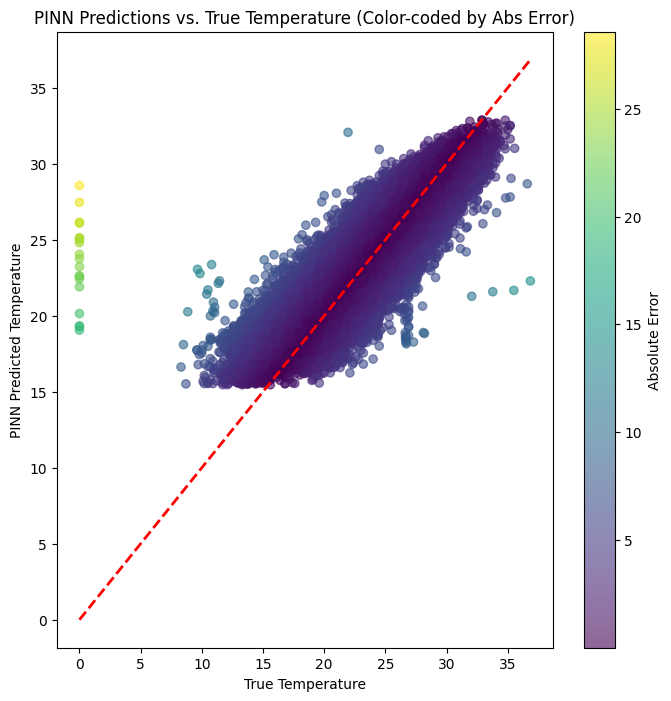

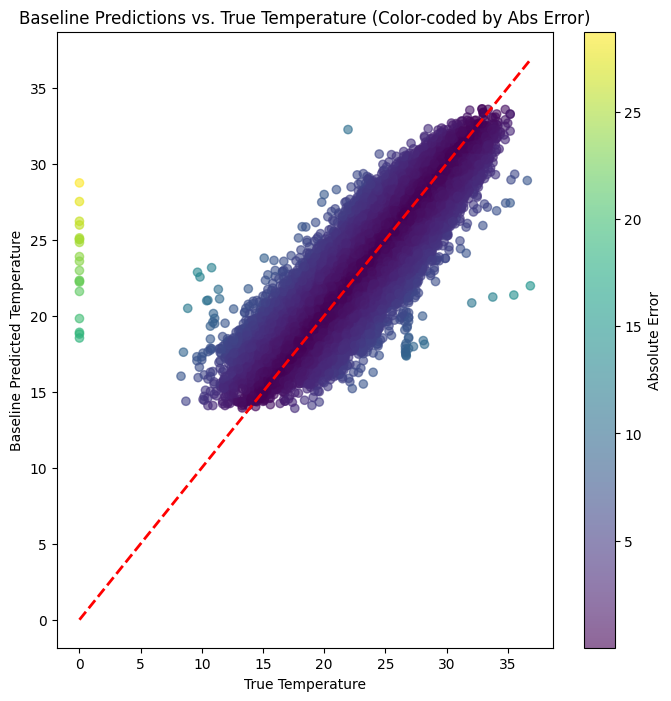

In [44]:
# Enhanced Scatter Plot
# Calculate the absolute errors for color mapping
plot_data['PINN_Abs_Error'] = abs(plot_data['PINN_Residuals'])
plot_data['Baseline_Abs_Error'] = abs(plot_data['Baseline_Residuals'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(plot_data['True_Temperature'], plot_data['PINN_Prediction'],
                      c=plot_data['PINN_Abs_Error'], cmap='viridis', alpha=0.6, label='PINN Predictions')
plt.plot([plot_data['True_Temperature'].min(), plot_data['True_Temperature'].max()],
         [plot_data['True_Temperature'].min(), plot_data['True_Temperature'].max()],
         'r--', lw=2)
plt.xlabel('True Temperature')
plt.ylabel('PINN Predicted Temperature')
plt.title('PINN Predictions vs. True Temperature (Color-coded by Abs Error)')
plt.colorbar(scatter, label='Absolute Error')
plt.show()

plt.figure(figsize=(8, 8))
scatter = plt.scatter(plot_data['True_Temperature'], plot_data['Baseline_Prediction'],
                      c=plot_data['Baseline_Abs_Error'], cmap='viridis', alpha=0.6, label='Baseline Predictions')
plt.plot([plot_data['True_Temperature'].min(), plot_data['True_Temperature'].max()],
         [plot_data['True_Temperature'].min(), plot_data['True_Temperature'].max()],
         'r--', lw=2)
plt.xlabel('True Temperature')
plt.ylabel('Baseline Predicted Temperature')
plt.title('Baseline Predictions vs. True Temperature (Color-coded by Abs Error)')
plt.colorbar(scatter, label='Absolute Error')
plt.show()